In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# === Set the shared path and load data set ===
base_path = r'G:\csv_outputs'
df_combined = pd.read_csv(f"{base_path}\\Combined_4Condition_Cleaned.csv")

# === Optional: print shapes for quick verification ===
print(f"Combined shape: {df_combined.shape}")

Combined shape: (159, 62)


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd

# === STEP 1: Prepare features and labels ===
X = df_combined.drop(columns=['Subject_ID', 'Label'])
y = df_combined['Label']
subject_ids = df_combined['Subject_ID']

# === STEP 2: Train-test split (keep test untouched)
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, subject_ids, test_size=0.2, stratify=y, random_state=42)

# Feature selection(RF) > Scalling > MLP

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
✅ Best Params: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,), 'mlp__learning_rate': 'invscaling', 'mlp__learning_rate_init': 0.1, 'mlp__momentum': 0.5, 'mlp__solver': 'sgd'}
📘 Classification Report (Train):
              precision    recall  f1-score   support

     Control       0.79      0.84      0.81        96
        ADHD       0.38      0.29      0.33        31

    accuracy                           0.71       127
   macro avg       0.58      0.57      0.57       127
weighted avg       0.69      0.71      0.70       127

ROC AUC (Train): 0.7604166666666666


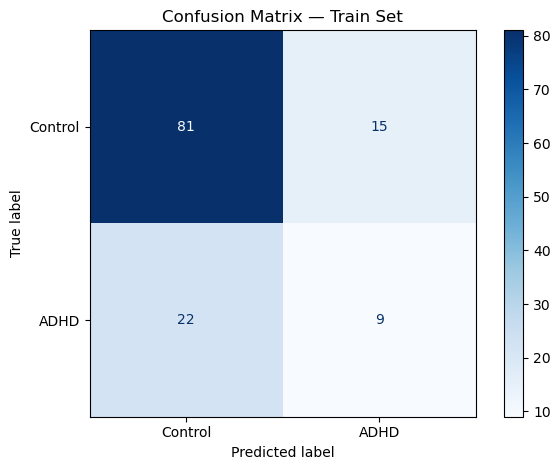

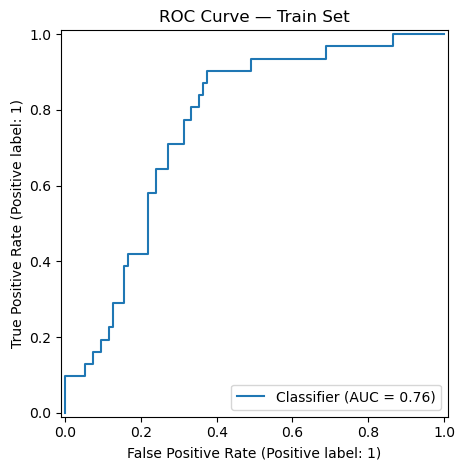

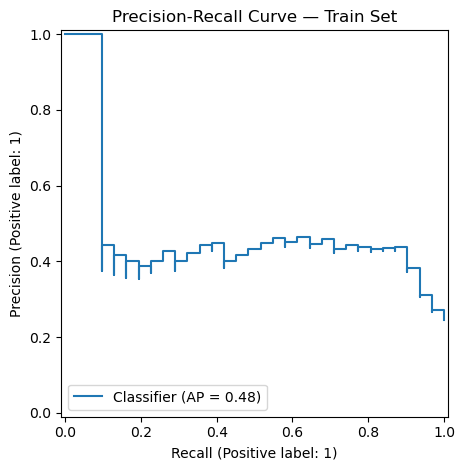


📊 Cross-Validated Scores:
fit_time: 0.6183
score_time: 0.0663
test_accuracy: 0.7108
train_accuracy: 0.7463
test_precision_macro: 0.6225
train_precision_macro: 0.6635
test_recall_macro: 0.6250
train_recall_macro: 0.6665
test_f1_macro: 0.6152
train_f1_macro: 0.6617
test_roc_auc: 0.6632
train_roc_auc: 0.7393

📘 Classification Report (Test):
              precision    recall  f1-score   support

     Control       0.79      0.79      0.79        24
        ADHD       0.38      0.38      0.38         8

    accuracy                           0.69        32
   macro avg       0.58      0.58      0.58        32
weighted avg       0.69      0.69      0.69        32

ROC AUC (Test): 0.6927083333333334


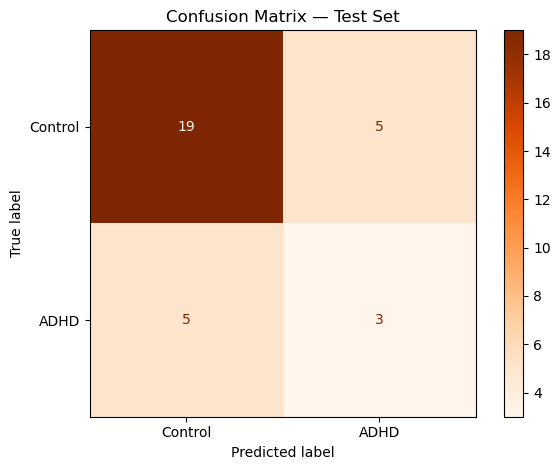

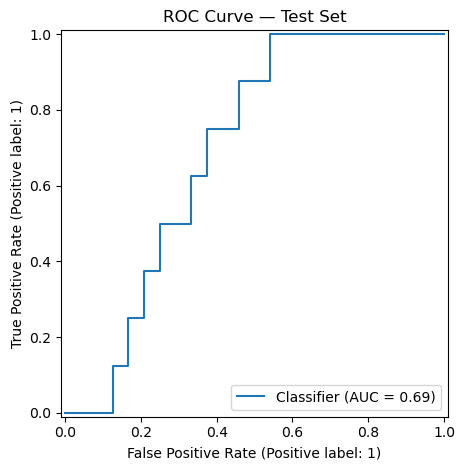

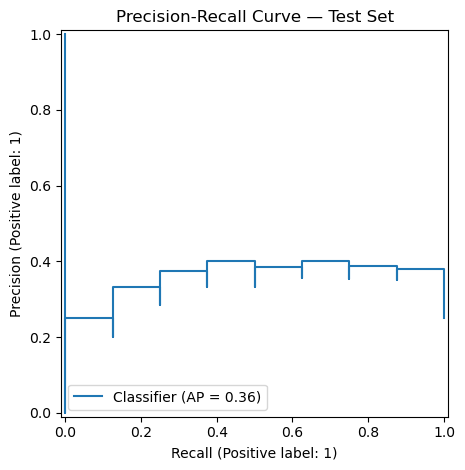

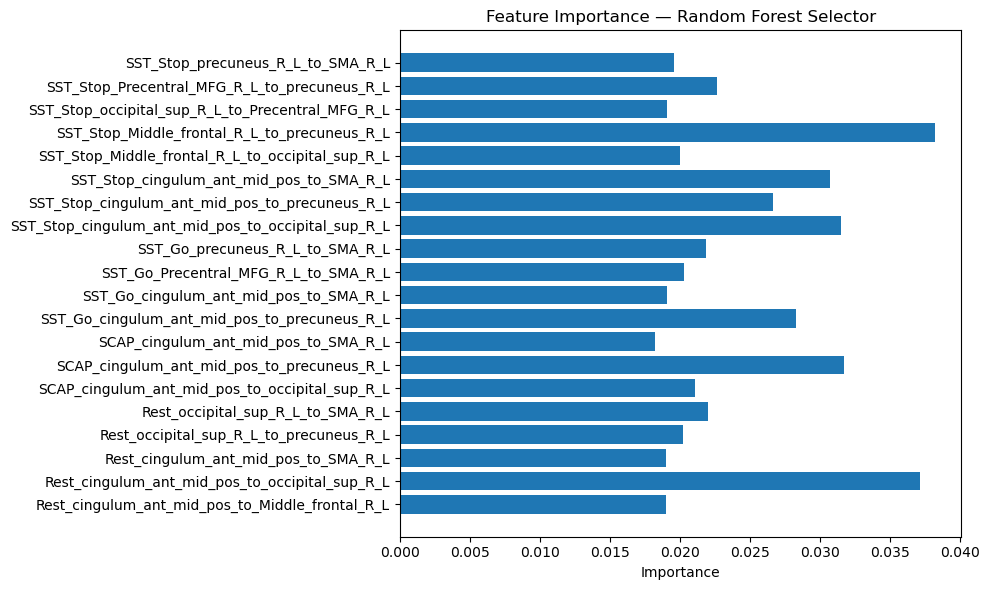

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, ConfusionMatrixDisplay,
    roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
)

# === CV Splits ===
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Random Forest for Feature Selection ===
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector = SelectFromModel(estimator=rf, threshold=-np.inf, max_features=20)

# === MLP Classifier (no fixed hyperparameters) ===
mlp = MLPClassifier(max_iter=1000, random_state=42)

# === Pipeline: Feature Selection -> Scaling -> MLP ===
pipeline = Pipeline([
    ('feature_select', rf_selector),
    ('scaler', StandardScaler()),
    ('mlp', mlp)
])

# === Wide Parameter Grid for MLP ===
param_grid = {
    'mlp__hidden_layer_sizes': [
        (50,), (100,), (150,),
        (100, 50), (50, 50), (100, 100), (50, 100, 50)
    ],
    'mlp__activation': ['relu', 'tanh', 'logistic'],
    'mlp__solver': ['adam', 'lbfgs', 'sgd'],
    'mlp__alpha': [0.0001, 0.001, 0.01, 0.1],
    'mlp__learning_rate_init': [0.001, 0.01, 0.1],
    'mlp__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'mlp__momentum': [0.5, 0.9]

}

# === Grid Search CV ===
grid_mlp = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro',
        'roc_auc': 'roc_auc'
    },
    refit='f1_macro',
    cv=inner_cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit the Model ===
grid_mlp.fit(X_train, y_train)
print("✅ Best Params:", grid_mlp.best_params_)

# === Train Predictions ===
y_train_pred = grid_mlp.predict(X_train)
y_train_proba = grid_mlp.predict_proba(X_train)[:, 1]

# === Evaluation Metrics (Train) ===
print("📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
plt.title("Confusion Matrix — Train Set")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train Set")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train Set")
plt.tight_layout()
plt.show()

# === Cross-Validated Scores ===
cv_scores = cross_validate(
    grid_mlp.best_estimator_,
    X, y,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    cv=outer_cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === TEST PREDICTIONS AND EVALUATION ===
y_test_pred = grid_mlp.predict(X_test)
y_test_proba = grid_mlp.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Control', 'ADHD'], cmap='Oranges')
plt.title("Confusion Matrix — Test Set")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve — Test Set")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve — Test Set")
plt.tight_layout()
plt.show()

# === 🔍 Feature Importance: Random Forest Selector ===
best_pipe = grid_mlp.best_estimator_
rf_selector = best_pipe.named_steps['feature_select']
rf_model = rf_selector.estimator_

selected_indices = rf_selector.get_support(indices=True)
selected_feature_names = X_train.columns[selected_indices]
rf_importances = rf_model.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(range(len(selected_indices)), rf_importances[selected_indices])
plt.yticks(range(len(selected_indices)), selected_feature_names)
plt.xlabel("Importance")
plt.title("Feature Importance — Random Forest Selector")
plt.tight_layout()
plt.show()


[learning_curve] Training set sizes: [ 14  28  42  57  71  85 100 114 128 143]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.2s finished


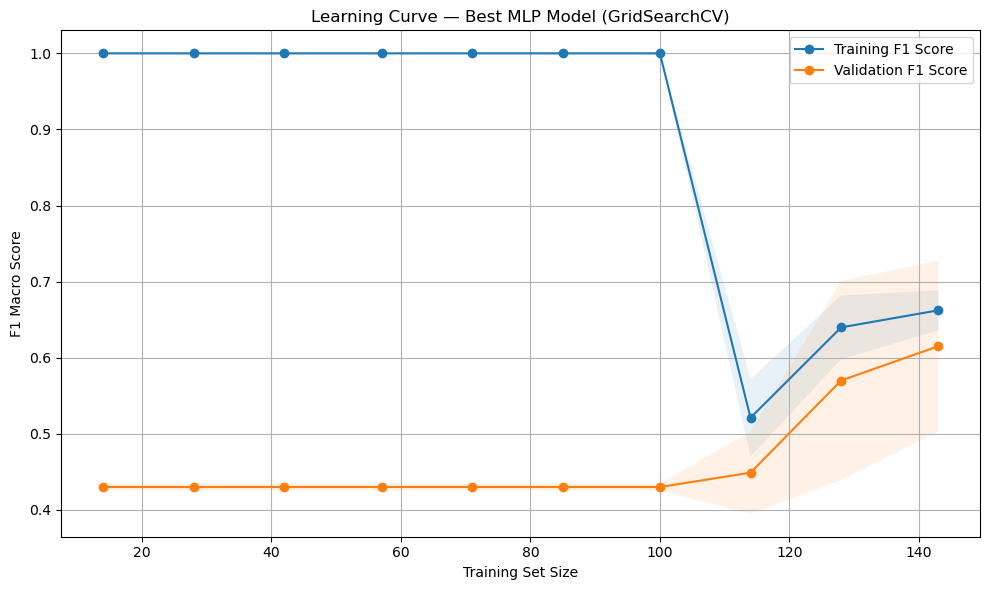

In [8]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# === Use the best estimator (MLP pipeline) from GridSearchCV ===
best_mlp_pipeline = grid_mlp.best_estimator_

# === Generate learning curve data ===
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_mlp_pipeline,
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=outer_cv,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# === Compute means and standard deviations ===
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# === Plot learning curve ===
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training F1 Score')
plt.plot(train_sizes, test_mean, 'o-', label='Validation F1 Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel("Training Set Size")
plt.ylabel("F1 Macro Score")
plt.title("Learning Curve — Best MLP Model (GridSearchCV)")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()
